In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np

import cartopy.crs as ccrs
import cartopy as cart
import cmocean
import torch
import torch.nn as nn
import torch.utils.data as data
import torch_geometric
from torch.nn import Sequential as Seq, Linear, ReLU
from Networks import *
from Data_Functions import *
from matplotlib.animation import FuncAnimation
from Utils import *
from Subgrid_Funcs import *
from Eval_Funcs import *
from Parallel import *
import numpy.fft as fft
import sys
import copy_things as copy
import scipy as sp
import matplotlib.ticker as ticker


In [3]:
exp_num_in = "3"
exp_num_extra = "5"
exp_num_out = "2"


mse = torch.nn.MSELoss()

region = "Tropics_Ext"   
network = "U_net"

interval = 2

N_samples = 2000
N_val = 100
N_test = 1000

Nb = 4

factor = 10

hist = 0

lag = 1

steps = 1

if len(sys.argv) > 4:
    n_cond = int((len(sys.argv)-4)/2)

str_video = ""

try:
    for i in range(n_cond):
        if type(globals()[sys.argv[int(4 + i*2)]]) == str:
            temp = str(sys.argv[int(5 + i*2)])
            exec(sys.argv[int(4 + i*2)] +"= temp" )
            if sys.argv[int(4 + i*2)] == "network":
                continue
            str_video += "_" + sys.argv[int(4 + i*2)] + "_" + sys.argv[int(5 + i*2)]
        elif type(globals()[sys.argv[int(4 + i*2)]]) == int:
            exec(sys.argv[int(4 + i*2)] +"=" + "int(" + sys.argv[int(5 + i*2)] +")" )
            str_video += "_" + sys.argv[int(4 + i*2)] + "_" + sys.argv[int(5 + i*2)]
    print(str_video)
except:
    print("no cond")

    
if region == "Kuroshio":
    lat = [15,41]
    lon = [-215, -185]
elif region == "Kuroshio_Ext":
    lat = [5,50]
    lon = [-250, -175]      
elif region == "Gulf_Stream":
    lat = [25, 50]
    lon = [-70,-35]
elif region == "Gulf_Stream_Ext":
    lat = [27, 50]
    lon = [-82,-35]       
elif region == "Tropics":
    lat = [-5,25]
    lon = [-95,-65]  
elif region == "Tropics_Ext":
    lat = [-5,25]
    lon = [-115,-45]     
elif region == "South_America":
    lat = [-60, -30]
    lon = [-70,-35] 
elif region == "Africa":
    lat = [-50, -20]
    lon = [5,45] 
elif region == "Quiescent":
    lat = [-42.5, -17.5]
    lon = [-155,-120] 
elif region == "Quiescent_Ext":
    lat = [-55, -10]
    lon = [-170,-110]            
elif region == "Pacific":
    lat = [-35, 35]
    lon = [-230,-80]     
elif region == "Indian":
    lat = [-30, 28]
    lon = [30,79]   
    
s_train = lag*hist
e_train = s_train + N_samples*interval
e_test = e_train + interval*N_val



device = "cpu"


inpt_dict = {"1":["um","vm"],"2":["um","vm","ur","vr"],"3":["um","vm","Tm"],
            "4":["um","vm","ur","vr","Tm","Tr"],"5":["ur","vr"],"6":["ur","vr","Tr"],
            "7":["Tm"],"8":["Tm","Tr"],"9":["u","v"],"10":["u","v","T"],
            "11":["tau_u","tau_v"]} 
extra_dict = {"1":["ur","vr"],"2":["ur","vr","Tm"],
            "3":["Tm"],"4":["ur","vr","Tm","Tr"],"5":[],"6":["um","vm"],
             "7":["um","vm","Tm"], "8": ["um","vm","Tm","Tr"],
              "9":["ur","vr","tau_u","tau_v"],"10":["tau_u","tau_v"],
              "11":["ur","vr","Tr"],"12":["tau_u","tau_v","t_ref"]} 
out_dict = {"1":["um","vm"],"2":["um","vm","Tm"],"3":["ur","vr"],
           "4":["ur","vr","Tr"],"5":["u","v"],"6":["u","v","T"]}


grids = xr.open_dataset('/scratch/zanna/data/CM2_grids/Grid_cm25_Vertices.nc')
if "global" in region:
    grids = coarse_grid(grids,factor)

else:
    grids = grids.sel({"yu_ocean":slice(lat[0],lat[1]),"xu_ocean":slice(lon[0],lon[1])})


area = torch.from_numpy(grids["area_C"].to_numpy()).to(device=device)
dx = grids["dxu"].to_numpy()
dy = grids["dyu"].to_numpy()



inputs = inpt_dict[exp_num_in]
extra_in = extra_dict[exp_num_extra]
outputs = out_dict[exp_num_out]

str_in = "".join([i + "_" for i in inputs])
str_ext = "".join([i + "_" for i in extra_in])
str_out = "".join([i + "_" for i in outputs])

print("inputs: " + str_in)
print("extra inputs: " + str_ext)
print("outputs: " + str_out)

N_atm = len(extra_in)
N_in = len(inputs)
N_extra = N_atm + N_in
N_out = len(outputs)

num_in = int((hist+1)*N_in + N_extra)

if "global" in region:
    inputs, extra_in, outputs = gen_data_global(inputs,extra_in,outputs,lag)
else:
    inputs, extra_in, outputs = inputs, extra_in, outputs = gen_data_025_lateral(inputs,extra_in,outputs,lag,lat,lon,Nb)


wet = xr.zeros_like(inputs[0][0])
# inputs[0][0,12,12] = np.nan
for data in inputs:
    wet +=np.isnan(data[0])
wet_nan = xr.where(wet!=0,np.nan,1).to_numpy()
wet = xr.where(wet==0,np.nan,0)    
wet_xr = wet.copy()
wet = np.isnan(wet)
wet = np.nan_to_num(wet.to_numpy())
wet = torch.from_numpy(wet).type(torch.float32).to(device=device)
wet_bool = np.array(wet.cpu()).astype(bool)

time_vec = inputs[0].time.data

no cond
inputs: um_vm_Tm_
extra inputs: 
outputs: um_vm_Tm_


/scratch/as15415/Emulation/Data_Functions.py:619: UserWarning: rename 'lat' to 'yu_ocean' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_atmos = data_atmos.rename({"lat":"yu_ocean","lon":"xu_ocean"})
/scratch/as15415/Emulation/Data_Functions.py:619: UserWarning: rename 'lon' to 'xu_ocean' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_atmos = data_atmos.rename({"lat":"yu_ocean","lon":"xu_ocean"})


In [4]:
clim = np.zeros((366,*wet.shape,3))
for i in range(N_out):
    clim[:,:,:,i] = outputs[i].groupby('time.dayofyear').mean('time').data

In [5]:
data_in_test = gen_data_in_test(0,e_test,N_test,lag,hist,inputs,extra_in)

data_out_test = gen_data_out_test(0,e_test,N_test,lag,hist,outputs)

test_data = data_CNN_Lateral(data_in_test,data_out_test,wet.to(device = "cpu"),N_atm,Nb,device="cpu") 

time_test = time_vec[e_test:(e_test+lag*N_test)]

mean_out = test_data.norm_vals['m_out']  
std_out = test_data.norm_vals['s_out']  
mean_in = test_data.norm_vals['m_in']  
std_in = test_data.norm_vals['s_in']  

In [10]:
def get_stats(region,N_IC,rand_int,str_in,str_ext,test_data,clim,time,area,wet_bool,N_mean,lag):
    extra_dict = {"5":[],"10":["tau_u","tau_v"],
                  "11":["t_ref"],"12":["tau_u","tau_v","t_ref"]}     
    str_ext = "".join([i + "_" for i in extra_dict[lag]])    
#     model_pred_atm = xr.open_zarr("/scratch/as15415/Emulation/Preds/Pred_Short_Data_025_"+region+"_in_"+str_in+"ext_"+str_ext+"lam_"+str(lag)+"_rand_seed_"+str(rand_int)+".zarr").to_array().to_numpy().squeeze()
#     model_pred_atm = xr.open_zarr("/scratch/as15415/Emulation/Preds/Pred_Short_Data_025_"+region+"_in_"+str_in+"ext_"+str_ext+"steps_"+str(lag)+"_rand_seed_"+str(rand_int)+".zarr").to_array().to_numpy().squeeze()
#     model_pred_atm = xr.open_zarr("/scratch/as15415/Emulation/Preds/Pred_Short_Data_Smooth_025_"+region+"_in_"+str_in+"ext_"+str_ext+"steps_"+str(lag)+"_rand_seed_"+str(rand_int)+".zarr").to_array().to_numpy().squeeze()
    model_pred_atm = xr.open_zarr("/scratch/as15415/Emulation/Preds/Pred_Short_Data_025_"+region+"_in_"+str_in+"ext_"+str_ext+"N_samples_"+str(4000)+"_rand_seed_"+str(rand_int)+".zarr").to_array().to_numpy().squeeze()

    #     model_pred_atm = xr.open_zarr("/scratch/as15415/Emulation/Preds/Pred_Short_Data_filtered_025_"+region+"_in_"+str_in+"ext_"+str_ext+"lam_"+str(lag)+"_rand_seed_"+str(rand_int)+".zarr").to_array().to_numpy().squeeze()

    #     model_pred_atm = xr.open_zarr("/scratch/as15415/Emulation/Preds/Pred_Short_Data_masked_025_"+region+"_in_"+str_in+"ext_"+str_ext+"lam_"+str(lag)+"_rand_seed_"+str(rand_int)+".zarr").to_array().to_numpy().squeeze()
    
    temp = copy.deepcopy(test_data)   
    temp.input = temp.input[int((N_IC-1)*N_mean):int((N_IC)*N_mean)]
    temp.output = temp.output[int((N_IC-1)*N_mean):int((N_IC+1)*N_mean)]
    temp.size = N_mean
    rmse_atm,auto_rmse = compute_rmse(N_mean,temp,model_pred_atm[int((N_IC-1)*N_mean):int((N_IC)*N_mean)],area.cpu(),wet_bool)
    corrs_atm,auto_corrs = compute_corrs_area(N_mean,temp,model_pred_atm[int((N_IC-1)*N_mean):int((N_IC)*N_mean)],area.cpu(),wet_bool)
    ACC_atm, auto_ACC = compute_ACC(N_mean,temp,model_pred_atm[int((N_IC-1)*N_mean):int((N_IC)*N_mean)],clim,time,area.cpu(),wet_bool)
    KE, auto_KE = compute_KE(N_mean,temp,model_pred_atm[int((N_IC-1)*N_mean):int((N_IC)*N_mean)],area,wet_bool)
    return rmse_atm, auto_rmse, corrs_atm, auto_corrs, ACC_atm, auto_ACC, KE, auto_KE

In [7]:
def get_spred(region,N_IC,num_IC,str_in,str_ext,test_data,clim,time,area,wet_bool,N_mean,lag):
    KE = np.zeros((int(num_IC*N_IC),N_mean))    
    rmse = np.zeros((int(num_IC*N_IC),N_mean,3))
    corrs = np.zeros((int(num_IC*N_IC),N_mean,3))
    ACC = np.zeros((int(num_IC*N_IC),N_mean,3))
    
    auto_KE = np.zeros((N_IC,N_mean))    
    auto_rmse = np.zeros((N_IC,N_mean,3))
    auto_corrs = np.zeros((N_IC,N_mean,3))   
    auto_ACC = np.zeros((N_IC,N_mean,3))    
    
    for i in range(0,num_IC):
        print(i)
        for j in range(0,N_IC):
            rmse_1, auto_rmse_1, corrs_1, auto_corrs_1, ACC_1, auto_acc_1, KE_1, auto_KE_1 = get_stats(region,j+1,i+1,str_in,str_ext,test_data,clim,time,area,wet_bool,N_mean,lag)
            KE[int(i*N_IC+j)] = KE_1
            rmse[int(i*N_IC+j)] = rmse_1
            corrs[int(i*N_IC+j)] = corrs_1
            ACC[int(i*N_IC+j)] = ACC_1
            
            if i ==0:
                auto_rmse[j] = auto_rmse_1
                auto_KE[j] = auto_KE_1
                auto_corrs[j] = auto_corrs_1
                auto_ACC[j] = auto_acc_1
                
    return rmse, corrs, ACC, KE, auto_rmse, auto_corrs, auto_ACC,auto_KE


In [ ]:
rmse_5, corrs_5, ACC_5, KE_5, auto_rmse,auto_corrs,auto_ACC,auto_KE = get_spred(region,5,3,str_in,str_ext,test_data,clim,time_test,area,wet_bool,200,"5")
rmse_10, corrs_10, ACC_10, KE_10, auto_rmse,auto_corrs,auto_ACC,auto_KE = get_spred(region,5,3,str_in,str_ext,test_data,clim,time_test,area,wet_bool,200,"10")
rmse_11, corrs_11, ACC_11, KE_11, auto_rmse,auto_corrs,auto_ACC,auto_KE = get_spred(region,5,3,str_in,str_ext,test_data,clim,time_test,area,wet_bool,200,"11")
rmse_12, corrs_12, ACC_12, KE_12, auto_rmse,auto_corrs,auto_ACC,auto_KE = get_spred(region,5,3,str_in,str_ext,test_data,clim,time_test,area,wet_bool,200,"12")

0
1
2
0
1
2
0
1
2
0
1
2


In [ ]:
N = 5

plt.style.use('bmh')

clist_1 = [cmocean.cm.thermal(i/(N-.5)) for i in range(1,N)]
clist_2 = ['#d7191c','#abd9e9','#2c7bb6','#fdae61']
clist_3 = ["#91B59A","#D6A922","#1E88E5","#A00B41"]
clist = clist_3

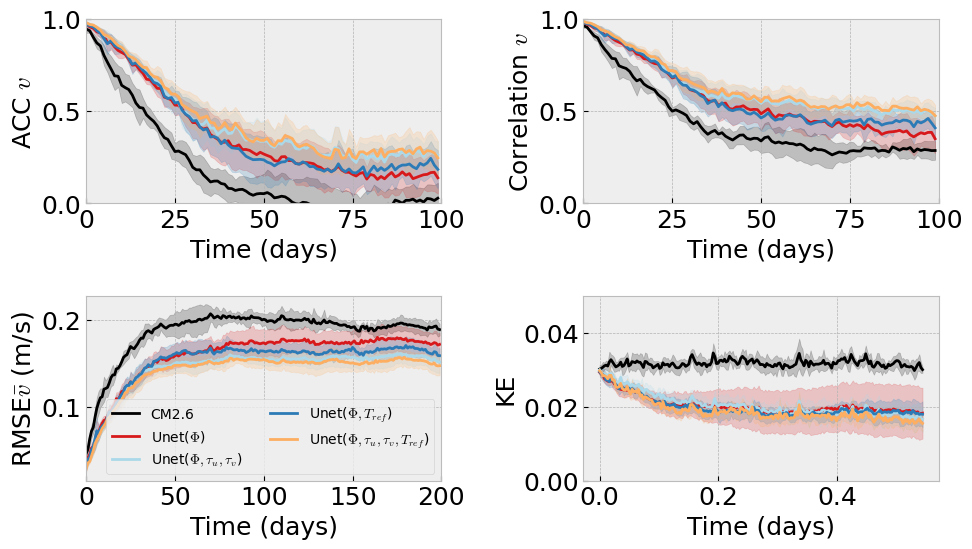

In [171]:
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=18)


fig, axs = plt.subplots(2, 2, figsize=(11,6),
                        gridspec_kw={'width_ratios': [1,1], 'height_ratios': [1,1], 'wspace': 0.4,'hspace':.5})
plot_acc((0,0),1)
plot_corr((0,1),1)
plot_rmse((1,0),1)
plot_KE((1,1))

In [ ]:
def plot_acc(plt_ind_acc,index):
    T_plot = 100


    N_int = int(T_plot/lag)
    N_true = min(N_test,N_int)

    var_list = {"1":r"$\bar{v}$ (m/s)","0":r"$\bar{u}$ (m/s)","2":r"$\bar{T} ~ (^\circ C)$"}


    
    axs[plt_ind_acc].plot((np.arange(N_int)*lag),auto_ACC.mean(axis=0)[:N_int,index],color="dimgrey",label = "$\mathbf{\Phi}(t=0)$")
    axs[plt_ind_acc].fill_between((np.arange(N_int)*lag),auto_ACC.mean(axis=0)[:N_int,index]-auto_ACC.std(axis=0)[:N_int,index],
                     auto_ACC.mean(axis=0)[:N_int,index]+auto_ACC.std(axis=0)[:N_int,index],
                     ls="-",color="dimgrey",alpha=.2)
    # axs[plt_ind_acc].plot((np.arange(N_int)*lag),auto_ACC.mean(axis=0)[:N_int,index]-auto_ACC.std(axis=0)[:N_int,index],ls="-",color="dimgrey",alpha=.75)
    # axs[plt_ind_acc].plot((np.arange(N_int)*lag),auto_ACC.mean(axis=0)[:N_int,index]+auto_ACC.std(axis=0)[:N_int,index],ls="-",color="dimgrey",alpha=.75)

    axs[plt_ind_acc].plot((np.arange(N_int)*lag),ACC_5.mean(axis=0)[:N_int,index],color=clist[0],label=r"Unet($\mathbf{\mathbf{\Phi}}$)")
    axs[plt_ind_acc].fill_between((np.arange(N_int)*lag),ACC_5.mean(axis=0)[:N_int,index]-ACC_5.std(axis=0)[:N_int,index],
                     ACC_5.mean(axis=0)[:N_int,index]+ACC_5.std(axis=0)[:N_int,index],
                     ls="-",color=clist[0],alpha=.2)

    axs[plt_ind_acc].plot((np.arange(N_int)*lag),ACC_10.mean(axis=0)[:N_int,index],color=clist[1],label=r"Unet($\mathbf{\Phi},\tau_u,\tau_v$)")
    axs[plt_ind_acc].fill_between((np.arange(N_int)*lag),ACC_10.mean(axis=0)[:N_int,index]-ACC_10.std(axis=0)[:N_int,index],
                     ACC_10.mean(axis=0)[:N_int,index]+ACC_10.std(axis=0)[:N_int,index],
                     ls="-",color=clist[1],alpha=.2)

    axs[plt_ind_acc].plot((np.arange(N_int)*lag),ACC_11.mean(axis=0)[:N_int,index],color=clist[2],label=r"Unet($\mathbf{\Phi},T_{ref}$)")
    axs[plt_ind_acc].fill_between((np.arange(N_int)*lag),ACC_11.mean(axis=0)[:N_int,index]-ACC_11.std(axis=0)[:N_int,index],
                     ACC_11.mean(axis=0)[:N_int,index]+ACC_11.std(axis=0)[:N_int,index],
                     ls="-",color=clist[2],alpha=.2)

    axs[plt_ind_acc].plot((np.arange(N_int)*lag),ACC_12.mean(axis=0)[:N_int,index],color=clist[3],label=r"Unet($\mathbf{\Phi},\tau_u,\tau_v,T_{ref}$)")
    axs[plt_ind_acc].fill_between((np.arange(N_int)*lag),ACC_12.mean(axis=0)[:N_int,index]-ACC_12.std(axis=0)[:N_int,index],
                     ACC_12.mean(axis=0)[:N_int,index]+ACC_12.std(axis=0)[:N_int,index],
                     ls="-",color=clist[3],alpha=.2)


    axs[plt_ind_acc].set_ylabel(r"ACC $" +var_list[str(index)][6]+"$")
    axs[plt_ind_acc].set_xlabel("Time (days)")


    axs[plt_ind_acc].set_ylim([0,1])
    axs[plt_ind_acc].set_xlim([0,T_plot])
#     axs[plt_ind_acc].legend(ncol=2)

#     axs[plt_ind_acc].set_title("Short Rollout "+ region)


In [ ]:
def plot_corr(plt_ind_acc,index):


    T_plot = 100

    N_int = int(T_plot/lag)
    N_true = min(N_test,N_int)

    var_list = {"1":r"$\bar{v}$ (m/s)","0":r"$\bar{u}$ (m/s)","2":r"$\bar{T} ~ (^\circ C)$"}




    axs[plt_ind_acc].plot((np.arange(N_int)*lag),auto_corrs.mean(axis=0)[:N_int,index],color="dimgrey",label = "$\mathbf{\Phi}(t=0)$")
    axs[plt_ind_acc].fill_between((np.arange(N_int)*lag),auto_corrs.mean(axis=0)[:N_int,index]-auto_corrs.std(axis=0)[:N_int,index],
                     auto_corrs.mean(axis=0)[:N_int,index]+auto_corrs.std(axis=0)[:N_int,index],
                     ls="-",color="dimgrey",alpha=.2)

    axs[plt_ind_acc].plot((np.arange(N_int)*lag),corrs_5.mean(axis=0)[:N_int,index],color=clist[0],label=r"Unet($\mathbf{\mathbf{\Phi}}$)")
    axs[plt_ind_acc].fill_between((np.arange(N_int)*lag),corrs_5.mean(axis=0)[:N_int,index]-corrs_5.std(axis=0)[:N_int,index],
                     corrs_5.mean(axis=0)[:N_int,index]+corrs_5.std(axis=0)[:N_int,index],
                     ls="-",color=clist[0],alpha=.2)

    axs[plt_ind_acc].plot((np.arange(N_int)*lag),corrs_10.mean(axis=0)[:N_int,index],color=clist[1],label=r"Unet($\mathbf{\Phi},\tau_u,\tau_v$)")
    axs[plt_ind_acc].fill_between((np.arange(N_int)*lag),corrs_10.mean(axis=0)[:N_int,index]-corrs_10.std(axis=0)[:N_int,index],
                     corrs_10.mean(axis=0)[:N_int,index]+corrs_10.std(axis=0)[:N_int,index],
                     ls="-",color=clist[1],alpha=.2)

    axs[plt_ind_acc].plot((np.arange(N_int)*lag),corrs_11.mean(axis=0)[:N_int,index],color=clist[2],label=r"Unet($\mathbf{\Phi},T_{ref}$)")
    axs[plt_ind_acc].fill_between((np.arange(N_int)*lag),corrs_11.mean(axis=0)[:N_int,index]-corrs_11.std(axis=0)[:N_int,index],
                     corrs_11.mean(axis=0)[:N_int,index]+corrs_11.std(axis=0)[:N_int,index],
                     ls="-",color=clist[2],alpha=.2)

    axs[plt_ind_acc].plot((np.arange(N_int)*lag),corrs_12.mean(axis=0)[:N_int,index],color=clist[3],label=r"Unet($\mathbf{\Phi},\tau_u,\tau_v,T_{ref}$)")
    axs[plt_ind_acc].fill_between((np.arange(N_int)*lag),corrs_12.mean(axis=0)[:N_int,index]-corrs_12.std(axis=0)[:N_int,index],
                     corrs_12.mean(axis=0)[:N_int,index]+corrs_12.std(axis=0)[:N_int,index],
                     ls="-",color=clist[3],alpha=.2)




    axs[plt_ind_acc].set_ylabel(r"Correlation $" +var_list[str(index)][6]+"$")
    axs[plt_ind_acc].set_xlabel("Time (days)")


    axs[plt_ind_acc].set_ylim([0,1])
    axs[plt_ind_acc].set_xlim([0,T_plot])
#     axs[plt_ind_acc].legend(ncol=2)

#     axs[plt_ind_acc].set_title("Short Rollout "+ region)


In [ ]:
def plot_KE(plt_ind_acc):

    T_plot = 200

    N_int = int(T_plot/lag)
    N_true = min(N_test,N_int)

    var_list = {"1":r"$\bar{v}$ (m/s)","0":r"$\bar{u}$ (m/s)","2":r"$\bar{T} ~ (^\circ C)$"}




    axs[plt_ind_acc].plot((np.arange(N_int)*lag)/366,auto_KE[:N_int].mean(axis=0),color="dimgrey",label = "$\mathbf{\Phi}(t=0)$")
    axs[plt_ind_acc].fill_between((np.arange(N_int)*lag)/366,auto_KE.mean(axis=0)[:N_int]-auto_KE.std(axis=0)[:N_int],
                     auto_KE.mean(axis=0)[:N_int]+auto_KE.std(axis=0)[:N_int],
                     ls="-",color="dimgrey",alpha=.2)

    axs[plt_ind_acc].plot((np.arange(N_int)*lag)/366,KE_5.mean(axis=0)[:N_int],color=clist[0],label=r"Unet($\mathbf{\Phi}$)")
    axs[plt_ind_acc].fill_between((np.arange(N_int)*lag)/366,KE_5.mean(axis=0)[:N_int]-KE_5.std(axis=0)[:N_int],
                     KE_5.mean(axis=0)[:N_int]+KE_5.std(axis=0)[:N_int],
                     ls="-",color=clist[0],alpha=.2)

    axs[plt_ind_acc].plot((np.arange(N_int)*lag)/366,KE_10.mean(axis=0)[:N_int],color=clist[1],label=r"Unet($\mathbf{\Phi},\tau_u,\tau_v$)")
    axs[plt_ind_acc].fill_between((np.arange(N_int)*lag)/366,KE_10.mean(axis=0)[:N_int]-KE_10.std(axis=0)[:N_int],
                     KE_10.mean(axis=0)[:N_int]+KE_10.std(axis=0)[:N_int],
                     ls="-",color=clist[1],alpha=.2)

    axs[plt_ind_acc].plot((np.arange(N_int)*lag)/366,KE_11.mean(axis=0)[:N_int],color=clist[2],label=r"Unet($\mathbf{\Phi},T_{ref}$)")
    axs[plt_ind_acc].fill_between((np.arange(N_int)*lag)/366,KE_11.mean(axis=0)[:N_int]-KE_11.std(axis=0)[:N_int],
                     KE_11.mean(axis=0)[:N_int]+KE_11.std(axis=0)[:N_int],
                     ls="-",color=clist[2],alpha=.2)

    axs[plt_ind_acc].plot((np.arange(N_int)*lag)/366,KE_12.mean(axis=0)[:N_int],color=clist[3],label=r"Unet($\mathbf{\Phi},\tau_u,\tau_v,T_{ref}$)")
    axs[plt_ind_acc].fill_between((np.arange(N_int)*lag)/366,KE_12.mean(axis=0)[:N_int]-KE_12.std(axis=0)[:N_int],
                     KE_12.mean(axis=0)[:N_int]+KE_12.std(axis=0)[:N_int],
                     ls="-",color=clist[3],alpha=.2)

    axs[plt_ind_acc].set_ylabel(r"KE")
    axs[plt_ind_acc].set_xlabel("Time (days)")

    axs[plt_ind_acc].set_ylim([0,.05])
    # axs[plt_ind_acc].set_yticks([-.1,-.05,0,.05,.1])
#     axs[plt_ind_acc].legend(ncol=2)

#     if region == "Quiescent":
#         axs[plt_ind_acc].set_title("Long Rollout South Pacific")
#     else:
#         axs[plt_ind_acc].set_title("Long Rollout "+ region)

    # plt.tight_layout()
    # plt.savefig("/scratch/as15415/Emulation/Figures/Comp_KE_region"+region+".png",bbox_inches='tight')

In [ ]:
def plot_rmse(plt_ind_acc,index):
    T_plot = 200

    N_int = int(T_plot/lag)
    N_true = min(N_test,N_int)


    var_list = {"1":r"$\bar{v}$ (m/s)","0":r"$\bar{u}$ (m/s)","2":r"$\bar{T} ~ (^\circ C)$"}


    axs[plt_ind_acc].plot((np.arange(N_int)*lag),auto_rmse.mean(axis=0)[:N_int,index],color="dimgrey",label = "$\mathbf{\Phi}(t=0)$")
    axs[plt_ind_acc].fill_between((np.arange(N_int)*lag),auto_rmse.mean(axis=0)[:N_int,index]-auto_rmse.std(axis=0)[:N_int,index]
                     ,auto_rmse.mean(axis=0)[:N_int,index]+auto_rmse.std(axis=0)[:N_int,index],
                     ls="-",color="dimgrey",alpha=.2)

    axs[plt_ind_acc].plot((np.arange(N_int)*lag),rmse_5.mean(axis=0)[:N_int,index],color=clist[0],label=r"Unet($\mathbf{\mathbf{\Phi}}$)")
    axs[plt_ind_acc].fill_between((np.arange(N_int)*lag),rmse_5.mean(axis=0)[:N_int,index]-rmse_5.std(axis=0)[:N_int,index],
                     rmse_5.mean(axis=0)[:N_int,index]+rmse_5.std(axis=0)[:N_int,index],
                     ls="-",color=clist[0],alpha=.2)

    axs[plt_ind_acc].plot((np.arange(N_int)*lag),rmse_10.mean(axis=0)[:N_int,index],color=clist[1],label=r"Unet($\mathbf{\Phi},\tau_u,\tau_v$)")
    axs[plt_ind_acc].fill_between((np.arange(N_int)*lag),rmse_10.mean(axis=0)[:N_int,index]-rmse_10.std(axis=0)[:N_int,index],
                     rmse_10.mean(axis=0)[:N_int,index]+rmse_10.std(axis=0)[:N_int,index],
                     ls="-",color=clist[1],alpha=.2)

    axs[plt_ind_acc].plot((np.arange(N_int)*lag),rmse_11.mean(axis=0)[:N_int,index],color=clist[2],label=r"Unet($\mathbf{\Phi},T_{ref}$)")
    axs[plt_ind_acc].fill_between((np.arange(N_int)*lag),rmse_11.mean(axis=0)[:N_int,index]-rmse_11.std(axis=0)[:N_int,index],
                     rmse_11.mean(axis=0)[:N_int,index]+rmse_11.std(axis=0)[:N_int,index],
                     ls="-",color=clist[2],alpha=.2)

    axs[plt_ind_acc].plot((np.arange(N_int)*lag),rmse_12.mean(axis=0)[:N_int,index],color=clist[3],label=r"Unet($\mathbf{\Phi},\tau_u,\tau_v,T_{ref}$)")
    axs[plt_ind_acc].fill_between((np.arange(N_int)*lag),rmse_12.mean(axis=0)[:N_int,index]-rmse_12.std(axis=0)[:N_int,index],
                     rmse_12.mean(axis=0)[:N_int,index]+rmse_12.std(axis=0)[:N_int,index],
                     ls="-",color=clist[3],alpha=.2)




    axs[plt_ind_acc].set_ylabel(r"RMSE" +var_list[str(index)])
    axs[plt_ind_acc].set_xlabel("Time (days)")


    # axs[plt_ind_acc].set_ylim([0,.25])
    # axs[plt_ind_acc].set_yticks([0,0.05,.1,.15,.2,.25])
    axs[plt_ind_acc].set_xlim([0,T_plot])
    axs[plt_ind_acc].legend(ncol=2)
    if index == 2:
        axs[plt_ind_acc].set_ylim([0,8])
    #     axs[plt_ind_acc].set_yticks([0,1,2,3,4,5])
    if index == 1 or index == 0:
        axs[plt_ind_acc].yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True, useOffset=False))
        axs[plt_ind_acc].ticklabel_format(axis='y', style='sci', scilimits=(0,0))   
